//content/drive/MyDrive/Colab Notebooks/cloud_detection.ipynb

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"🖥️  Device: {device}")

if device.type == "cuda":
    print(f"🚀 GPU: {torch.cuda.get_device_name(0)}")
    print(f"🔧 CUDA Version: {torch.version.cuda}")
    print(f"📦 Memory Allocated: {torch.cuda.memory_allocated() / 1024**2:.1f} MB")
else:
    print("⚠️ WARNING: GPU is not enabled!")


🖥️  Device: cuda
🚀 GPU: Tesla T4
🔧 CUDA Version: 12.6
📦 Memory Allocated: 0.0 MB


In [ ]:
!pip install -q kaggle
!pip install -q torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu118
!pip install -q albumentations==1.3.0 rasterio opencv-python matplotlib seaborn tqdm

In [ ]:
# Install Kaggle API and other libraries needed
!pip install -q kaggle torch torchvision albumentations rasterio matplotlib opencv-python tqdm

# Make kaggle folder
!mkdir -p ~/.kaggle

In [ ]:
# --- Install dependencies ---
!pip install kagglehub rasterio albumentations==1.3.1 matplotlib scikit-learn torch torchvision tqdm --quiet

# --- Imports ---
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
import rasterio
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import albumentations as A
from tqdm import tqdm
import random

print("✅ Libraries installed and imported successfully")

✅ Libraries installed and imported successfully


In [ ]:
# import kagglehub

# # Download the 38-Cloud dataset
# path = kagglehub.dataset_download("sorour/38cloud-cloud-segmentation-in-satellite-images")
# print("✅ Dataset downloaded to:", path)

# # # List a few files
# # !ls "$path" | head -n 20


Resuming download from 6592397312 bytes (6464244049 bytes left)...
Resuming download from https://www.kaggle.com/api/v1/datasets/download/sorour/38cloud-cloud-segmentation-in-satellite-images?dataset_version_number=4 (6592397312/13056641361) bytes left.


100%|██████████| 12.2G/12.2G [04:51<00:00, 22.2MB/s]

Extracting files...


✅ Dataset downloaded to: /root/.cache/kagglehub/datasets/sorour/38cloud-cloud-segmentation-in-satellite-images/versions/4


In [ ]:
# drive_destination = "/content/drive/My Drive/Kaggle_Datasets/38-Cloud"
# os.makedirs(drive_destination, exist_ok=True) # Creates the folder if it doesn't exist

# # --- 3. Move the Files ---
# print(f"🚚 Moving files from '{path}' to '{drive_destination}'...")
# !mv "{path}"/* "{drive_destination}"

# print("✅ All files have been successfully moved to your Google Drive!")

🚚 Moving files from '/root/.cache/kagglehub/datasets/sorour/38cloud-cloud-segmentation-in-satellite-images/versions/4' to '/content/drive/My Drive/Kaggle_Datasets/38-Cloud'...
✅ All files have been successfully moved to your Google Drive!


In [ ]:
# import os

# for root, dirs, files in os.walk(path):
#     level = root.replace(path, '').count(os.sep)
#     indent = ' ' * 2 * (level)
#     print(f"{indent}{os.path.basename(root)}/")
#     subindent = ' ' * 2 * (level + 1)
#     for f in files[:5]:  # show first 5 files per folder
#         print(f"{subindent}{f}")


In [ ]:
# Base path to training data inside downloaded dataset
path = "/content/drive/My Drive/Kaggle_Datasets/38-Cloud"
base_train_path = os.path.join(path, '38-Cloud_training')

train_red_path   = os.path.join(base_train_path, 'train_red')
train_green_path = os.path.join(base_train_path, 'train_green')
train_blue_path  = os.path.join(base_train_path, 'train_blue')
train_gt_path    = os.path.join(base_train_path, 'train_gt')  # ground truth masks

# Check how many files we have in each band/mask
import glob

n_red   = len(glob.glob(os.path.join(train_red_path, '*.TIF')))
n_green = len(glob.glob(os.path.join(train_green_path, '*.TIF')))
n_blue  = len(glob.glob(os.path.join(train_blue_path, '*.TIF')))
n_masks = len(glob.glob(os.path.join(train_gt_path, '*.TIF')))

print(f"Red band patches:   {n_red}")
print(f"Green band patches: {n_green}")
print(f"Blue band patches:  {n_blue}")
print(f"Masks (GT):         {n_masks}")


Red band patches:   8400
Green band patches: 8400
Blue band patches:  8400
Masks (GT):         8400


/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/tmp/ipython-input-35776508.py:19: RuntimeWarning: invalid value encountered in divide
  rgb_img = (rgb_img - rgb_img.min()) / (rgb_img.max()-rgb_img.min())  # normalize to [0,1]


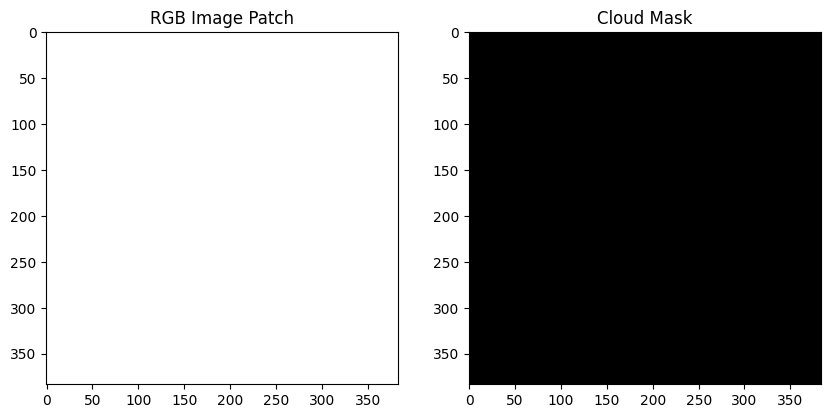

In [ ]:


# Pick a random patch from red folder
red_files   = sorted(glob.glob(os.path.join(train_red_path, '*.TIF')))
green_files = sorted(glob.glob(os.path.join(train_green_path, '*.TIF')))
blue_files  = sorted(glob.glob(os.path.join(train_blue_path, '*.TIF')))
mask_files  = sorted(glob.glob(os.path.join(train_gt_path, '*.TIF')))

idx = random.randint(0, len(red_files)-1)

# Read the bands
with rasterio.open(red_files[idx]) as src:
    red = src.read(1)
with rasterio.open(green_files[idx]) as src:
    green = src.read(1)
with rasterio.open(blue_files[idx]) as src:
    blue = src.read(1)

# Stack to RGB
rgb_img = np.dstack((red, green, blue)).astype(np.float32)
rgb_img = (rgb_img - rgb_img.min()) / (rgb_img.max()-rgb_img.min())  # normalize to [0,1]

# Read mask
with rasterio.open(mask_files[idx]) as src:
    mask = src.read(1)

# Plot
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.imshow(rgb_img)
plt.title('RGB Image Patch')
plt.subplot(1,2,2)
plt.imshow(mask, cmap='gray')
plt.title('Cloud Mask')
plt.show()

## Step 2 — PyTorch Dataset Class


In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

class CloudDataset(Dataset):
    def __init__(self, red_files, green_files, blue_files, mask_files, transform=None):
        self.red_files = red_files
        self.green_files = green_files
        self.blue_files = blue_files
        self.mask_files = mask_files
        self.transform = transform

    def __len__(self):
        return len(self.red_files)

    def __getitem__(self, idx):
        # Read image bands
        with rasterio.open(self.red_files[idx]) as src:
            red = src.read(1)
        with rasterio.open(self.green_files[idx]) as src:
            green = src.read(1)
        with rasterio.open(self.blue_files[idx]) as src:
            blue = src.read(1)

        # Read the ground truth mask
        with rasterio.open(self.mask_files[idx]) as src:
            mask = src.read(1)

        # Stack bands into an RGB image and normalize to [0, 1]
        img = np.dstack((red, green, blue)).astype(np.float32)
        img = (img - img.min()) / (img.max() - img.min() + 1e-6)

        # ✅ **FIX:** Normalize mask values from [0, 255] to [0, 1]
        mask = (mask / 255.0).astype(np.float32)

        # Convert to torch tensors
        img = torch.from_numpy(img).permute(2, 0, 1)  # (H, W, C) -> (C, H, W)
        mask = torch.from_numpy(mask).unsqueeze(0)    # (H, W) -> (1, H, W)

        return img, mask


In [ ]:
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader

# Split indices for training and validation sets
train_idx, val_idx = train_test_split(range(len(red_files)), test_size=0.2, random_state=42)

# Create training dataset
train_dataset = CloudDataset(
    [red_files[i] for i in train_idx],
    [green_files[i] for i in train_idx],
    [blue_files[i] for i in train_idx],
    [mask_files[i] for i in train_idx]
)

# Create validation dataset
val_dataset = CloudDataset(
    [red_files[i] for i in val_idx],
    [green_files[i] for i in val_idx],
    [blue_files[i] for i in val_idx],
    [mask_files[i] for i in val_idx]
)


# ✅ **FIX:** Set num_workers=0 to avoid multiprocessing errors in notebooks
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False, num_workers=0)

print(f"Train batches: {len(train_loader)}, Validation batches: {len(val_loader)}")

Train batches: 420, Validation batches: 105


Images shape: torch.Size([16, 3, 384, 384])
Masks shape: torch.Size([16, 1, 384, 384])


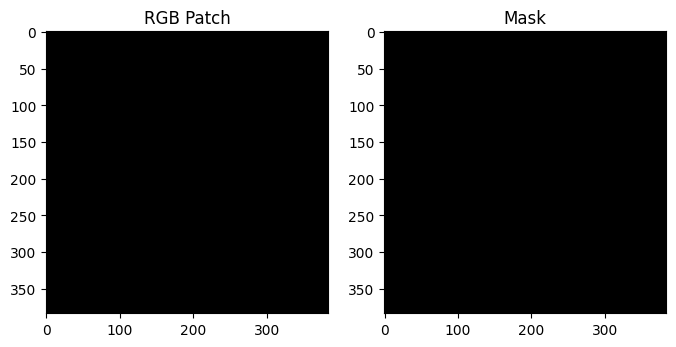

In [ ]:
imgs, masks = next(iter(train_loader))
print("Images shape:", imgs.shape)   # [B,3,H,W]
print("Masks shape:", masks.shape)   # [B,1,H,W]

# Plot first sample
plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
plt.imshow(imgs[0].permute(1,2,0))
plt.title('RGB Patch')
plt.subplot(1,2,2)
plt.imshow(masks[0][0], cmap='gray')
plt.title('Mask')
plt.show()


## Build the Model (UNet Lite)

In [ ]:
import torch.nn as nn

# Basic UNet block
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)

class UNet(nn.Module):
    def __init__(self, n_channels=3, n_classes=1):
        super().__init__()
        self.inc = DoubleConv(n_channels, 64)
        self.down1 = nn.Sequential(nn.MaxPool2d(2), DoubleConv(64, 128))
        self.down2 = nn.Sequential(nn.MaxPool2d(2), DoubleConv(128, 256))
        self.down3 = nn.Sequential(nn.MaxPool2d(2), DoubleConv(256, 512))
        self.up1 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.conv1 = DoubleConv(512, 256)
        self.up2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.conv2 = DoubleConv(256, 128)
        self.up3 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.conv3 = DoubleConv(128, 64)
        self.outc = nn.Conv2d(64, n_classes, kernel_size=1)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x = self.up1(x4)
        x = self.conv1(torch.cat([x, x3], dim=1))
        x = self.up2(x)
        x = self.conv2(torch.cat([x, x2], dim=1))
        x = self.up3(x)
        x = self.conv3(torch.cat([x, x1], dim=1))
        logits = self.outc(x)
        return logits

# Instantiate model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = UNet().to(device)
print("Model ready on", device)


Model ready on cuda


In [ ]:
# Check the loader:
for images, masks in train_loader:
    print(images.shape, masks.shape)
    break  # Only print for the first batch


torch.Size([16, 3, 384, 384]) torch.Size([16, 1, 384, 384])


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm.auto import tqdm
from torch.amp import autocast, GradScaler
import warnings

# Suppress non-critical warnings
warnings.filterwarnings("ignore", category=UserWarning)

# --- DEVICE SETUP ---
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# --- INITIALIZE MODEL, LOSS, OPTIMIZER, & SCALER ---
# Ensure model is defined and moved to the correct device
# model = UNet().to(device) # This should already be defined in a previous cell
model.to(device)

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)
# Use GradScaler only if a CUDA device is available
scaler = GradScaler(device='cuda')

# --- METRIC FUNCTIONS (IoU & Dice) ---
def compute_metrics(preds, masks, smooth=1e-6):
    """
    Computes Dice and IoU scores for a batch of predictions and masks.
    """
    # Sigmoid + threshold
    preds = torch.sigmoid(preds)
    preds = (preds > 0.5).float()
    masks = masks.float()

    # Flatten
    preds = preds.view(preds.size(0), -1)
    masks = masks.view(masks.size(0), -1)

    # Intersection & sums
    intersection = (preds * masks).sum(dim=1)
    preds_sum = preds.sum(dim=1)
    masks_sum = masks.sum(dim=1)
    union = preds_sum + masks_sum - intersection

    # Convert smooth to tensor on same device
    smooth_tensor = torch.tensor(smooth, device=preds.device)

    # Dice & IoU
    dice = (2.0 * intersection + smooth_tensor) / (preds_sum + masks_sum + smooth_tensor)
    iou = (intersection + smooth_tensor) / (union + smooth_tensor)

    return dice.mean().item(), iou.mean().item()



# --- TRAINING FUNCTION ---
def train_one_epoch(model, loader, optimizer, criterion, scaler, device):
    """
    Trains the model for one epoch.
    """
    model.train()
    running_loss = 0.0

    for images, masks in tqdm(loader, desc="Training", leave=False):
        images, masks = images.to(device), masks.to(device)

        optimizer.zero_grad()

        # Use automatic mixed precision if a scaler is available (on CUDA)
        if scaler:
            with autocast(device_type='cuda', dtype=torch.float16):
                outputs = model(images)
                loss = criterion(outputs, masks)
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
        else: # For CPU
            outputs = model(images)
            loss = criterion(outputs, masks)
            loss.backward()
            optimizer.step()


        running_loss += loss.item()

    avg_loss = running_loss / len(loader)
    return avg_loss

# --- VALIDATION FUNCTION ---
def validate(model, loader, criterion, device):
    """
    Validates the model on the validation dataset.
    """
    model.eval()
    running_loss = 0.0
    total_dice = 0.0
    total_iou = 0.0

    with torch.no_grad():
        for images, masks in tqdm(loader, desc="Validating", leave=False):
            images, masks = images.to(device), masks.to(device)

            # Use automatic mixed precision if on CUDA
            if torch.cuda.is_available():
                with autocast(device_type='cuda', dtype=torch.float16):
                    outputs = model(images)
                    loss = criterion(outputs, masks)
            else: # For CPU
                 outputs = model(images)
                 loss = criterion(outputs, masks)


            running_loss += loss.item()

            dice, iou = compute_metrics(outputs, masks)
            total_dice += dice
            total_iou += iou

    avg_loss = running_loss / len(loader)
    avg_dice = total_dice / len(loader)
    avg_iou = total_iou / len(loader)
    return avg_loss, avg_iou, avg_dice

# --- MAIN TRAINING LOOP ---
epochs = 10
best_val_iou = 0.0
history = {'train_loss': [], 'val_loss': [], 'val_iou': [], 'val_dice': []}
model_save_path = '/content/drive/MyDrive/colab_models/best_model.pth'


# for epoch in range(1, epochs + 1):
#     print(f"\n📘 Epoch {epoch}/{epochs}")

#     train_loss = train_one_epoch(model, train_loader, optimizer, criterion, scaler, device)
#     history['train_loss'].append(train_loss)
#     print(f"✅ Train Loss: {train_loss:.4f}")

#     val_loss, val_iou, val_dice = validate(model, val_loader, criterion, device)
#     history['val_loss'].append(val_loss)
#     history['val_iou'].append(val_iou)
#     history['val_dice'].append(val_dice)
#     print(f"🔍 Val Loss: {val_loss:.4f} | IoU: {val_iou:.4f} | Dice: {val_dice:.4f}")

#     # Save the model if it has the best validation IoU so far
#     if val_iou > best_val_iou:
#         best_val_iou = val_iou
#         torch.save(model.state_dict(), model_save_path)
#         print(f"💾 Best model saved with IoU: {best_val_iou:.4f}")

#     # Clear CUDA cache to free up memory
#     if torch.cuda.is_available():
#         torch.cuda.empty_cache()

print("\n🏁 Training Complete!")

Using device: cuda

🏁 Training Complete!


In [ ]:
pred = torch.tensor([[[[0,1],[1,0]]]], dtype=torch.float)
mask = torch.tensor([[[[1,1],[0,0]]]], dtype=torch.float)
dice, iou = compute_metrics(pred, mask)
print("dice = ",dice, "\nIOU = ", iou)

dice =  0.5000001192092896 
IOU =  0.3333335518836975


In [ ]:
print("Mask min:", masks.min().item(), "Mask max:", masks.max().item())

with torch.no_grad():
    out = model(images.to(device))
print("Output min:", out.min().item(), "Output max:", out.max().item())


Mask min: 0.0 Mask max: 1.0
Output min: -6.533498764038086 Output max: 4.180474758148193


In [ ]:
import torch
import numpy as np
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

def evaluate_all_in_one(
    model, loader, device, criterion=None, model_path='/content/drive/MyDrive/colab_models/best_model.pth',
    history=None, thresholds=np.linspace(0.1,0.9,9)
):
    """
    All-in-one evaluation:
    - Loss, Pixel Accuracy
    - Global & Mean IoU/Dice
    - Precision, Recall, F1
    - Confusion Matrix
    - IoU/Dice/Loss curves over epochs (if history provided)
    - Threshold sweep for IoU
    """

    # --- Load best model weights ---
    try:
        model.load_state_dict(torch.load(model_path, map_location=device))
        print(f"✅ Best model weights ('{model_path}') loaded successfully.")
    except FileNotFoundError:
        print(f"⚠️ '{model_path}' not found. Ensure training was completed.")
        return

    model.to(device)
    model.eval()

    all_preds_logits = []
    all_preds = []
    all_targets = []
    total_loss = 0.0
    total_batches = 0

    with torch.no_grad():
        for images, masks in tqdm(loader, desc="Evaluating Model"):
            images = images.to(device, dtype=torch.float)
            masks = masks.to(device, dtype=torch.float)

            outputs = model(images)
            probs = torch.sigmoid(outputs)

            preds = (probs > 0.5).float()

            all_preds_logits.append(probs.cpu())
            all_preds.append(preds.cpu())
            all_targets.append(masks.cpu())

            if criterion is not None:
                loss = criterion(outputs, masks)
                total_loss += loss.item()
                total_batches += 1

    all_preds_logits = torch.cat(all_preds_logits, dim=0)
    all_preds = torch.cat(all_preds, dim=0)
    all_targets = torch.cat(all_targets, dim=0)

    # --- Metrics ---
    avg_loss = total_loss / total_batches if total_batches > 0 else None

    # Pixel accuracy
    correct = (all_preds == all_targets).sum().item()
    total = all_targets.numel()
    pixel_accuracy = (correct / total) * 100

    # Flatten for global metrics
    preds_flat = all_preds.view(-1)
    targets_flat = all_targets.view(-1)

    intersection_global = (preds_flat * targets_flat).sum().item()
    union_global = preds_flat.sum().item() + targets_flat.sum().item() - intersection_global
    iou_global = (intersection_global + 1e-6) / (union_global + 1e-6)
    dice_global = (2. * intersection_global + 1e-6) / \
        (preds_flat.sum().item() + targets_flat.sum().item() + 1e-6)

    # Mean IoU/Dice per image
    intersection = (all_preds * all_targets).sum(dim=(1,2,3))
    union = all_preds.sum(dim=(1,2,3)) + all_targets.sum(dim=(1,2,3)) - intersection
    iou_mean = ((intersection + 1e-6) / (union + 1e-6)).mean().item()

    dice_mean = ((2 * intersection + 1e-6) /
                 (all_preds.sum(dim=(1,2,3)) + all_targets.sum(dim=(1,2,3)) + 1e-6)).mean().item()

    # Precision, Recall, F1 (pixel-wise)
    tp = (preds_flat * targets_flat).sum().item()
    fp = ((preds_flat == 1) & (targets_flat == 0)).sum().item()
    fn = ((preds_flat == 0) & (targets_flat == 1)).sum().item()
    precision = tp / (tp + fp + 1e-6)
    recall = tp / (tp + fn + 1e-6)
    f1_score = 2 * precision * recall / (precision + recall + 1e-6)

    # --- Confusion Matrix ---
    cm = confusion_matrix(targets_flat.numpy(), preds_flat.numpy(), labels=[0,1])
    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[0,1], yticklabels=[0,1])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix (pixels)')
    plt.show()

    # --- Threshold sweep IoU ---
    iou_vs_threshold = []
    for t in thresholds:
        preds_t = (all_preds_logits > t).float().view(-1)
        inter = (preds_t * targets_flat).sum().item()
        uni = preds_t.sum().item() + targets_flat.sum().item() - inter
        iou_vs_threshold.append((t, (inter + 1e-6) / (uni + 1e-6)))
    plt.figure(figsize=(6,4))
    plt.plot([x[0] for x in iou_vs_threshold], [x[1] for x in iou_vs_threshold], marker='o')
    plt.xlabel('Threshold')
    plt.ylabel('IoU')
    plt.title('IoU vs Threshold')
    plt.grid()
    plt.show()

    # --- History curves if provided ---
    if history is not None:
        plt.figure(figsize=(6,4))
        if 'val_loss' in history and 'train_loss' in history:
            plt.plot(history['train_loss'], label='Train Loss')
            plt.plot(history['val_loss'], label='Val Loss')
        if 'val_iou' in history:
            plt.plot(history['val_iou'], label='Val IoU')
        if 'val_dice' in history:
            plt.plot(history['val_dice'], label='Val Dice')
        plt.xlabel('Epoch')
        plt.title('Training History')
        plt.legend()
        plt.grid()
        plt.show()

    # --- Final report ---
    print("\n--- Final Performance Report ---")
    if avg_loss is not None:
        print(f"📉 Average Loss:          {avg_loss:.4f}")
    print(f"🎯 Pixel Accuracy:         {pixel_accuracy:.2f}%")
    print(f"📏 Precision:              {precision:.4f}")
    print(f"📏 Recall:                 {recall:.4f}")
    print(f"🎲 F1 Score:               {f1_score:.4f}")
    print("\n📐 IoU Scores:")
    print(f"    - Global IoU:          {iou_global:.4f}")
    print(f"    - Mean IoU (per image):{iou_mean:.4f}")
    print("\n🎲 Dice Scores:")
    print(f"    - Global Dice:         {dice_global:.4f}")
    print(f"    - Mean Dice (per image):{dice_mean:.4f}")
    print("------------------------------")

    return {
        'avg_loss': avg_loss,
        'pixel_accuracy': pixel_accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1_score,
        'iou_global': iou_global,
        'dice_global': dice_global,
        'iou_mean': iou_mean,
        'dice_mean': dice_mean,
        'iou_vs_threshold': iou_vs_threshold
    }

# --- Usage ---
criterion = torch.nn.BCEWithLogitsLoss()
history = None
results = evaluate_all_in_one(model, val_loader, device, criterion=criterion, history=history)


✅ Best model weights ('/content/drive/MyDrive/colab_models/best_model.pth') loaded successfully.


Evaluating Model:   0%|          | 0/105 [00:00<?, ?it/s]

In [ ]:
import matplotlib.pyplot as plt
import torch
import random
import numpy as np

def visualize_predictions(model, loader, device, num_samples=4):
    """
    Loads the best model and visualizes its predictions on a few random samples.
    """
    # --- 1. Load the best model weights ---
    try:
        model.load_state_dict(torch.load('/content/drive/MyDrive/colab_models/best_model.pth', map_location=device))
        print("✅ Best model weights loaded for visualization.")
    except FileNotFoundError:
        print("⚠️ 'best_model.pth' not found. Cannot visualize predictions.")
        return

    model.to(device)
    model.eval()

    # --- 2. Get a batch of data ---
    images, masks = next(iter(loader))

    # --- 3. Run model inference ---
    with torch.no_grad():
        outputs = model(images.to(device))
        # Convert logits to binary predictions
        preds = (torch.sigmoid(outputs) > 0.5).float()

    # Move data to CPU for plotting
    images = images.cpu()
    masks = masks.cpu()
    preds = preds.cpu()

    # --- 4. Plot the results ---
    plt.figure(figsize=(15, num_samples * 5))

    # Get random indices from the batch
    indices = random.sample(range(len(images)), min(num_samples, len(images)))

    for i, idx in enumerate(indices):
        # Original Image
        plt.subplot(num_samples, 3, i * 3 + 1)
        # Permute from (C, H, W) to (H, W, C) for displaying
        image_to_show = images[idx].permute(1, 2, 0)
        plt.imshow(image_to_show)
        plt.title(f"Original Image #{idx}")
        plt.axis('off')

        # Ground Truth Mask
        plt.subplot(num_samples, 3, i * 3 + 2)
        # Squeeze the channel dimension (1, H, W) -> (H, W)
        mask_to_show = masks[idx].squeeze()
        plt.imshow(mask_to_show, cmap='gray')
        plt.title("Ground Truth Mask")
        plt.axis('off')

        # Predicted Mask
        plt.subplot(num_samples, 3, i * 3 + 3)
        pred_to_show = preds[idx].squeeze()
        plt.imshow(pred_to_show, cmap='gray')
        plt.title("Predicted Mask")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# --- How to use the function ---
# Make sure 'model' and 'val_loader' are defined from your previous cells.
visualize_predictions(model, val_loader, device)

NameError: name 'model' is not defined

## Confusion matrix

In [ ]:
#gemini
import torch
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
from tqdm.auto import tqdm

def generate_detailed_report(model, loader, device):
    """
    Generates a detailed classification report and a confusion matrix heatmap.
    """
    # --- Load the best model weights ---
    try:
        model.load_state_dict(torch.load('/content/drive/MyDrive/colab_models/best_model.pth', map_location=device))
        print("✅ Best model weights loaded successfully.")
    except FileNotFoundError:
        print("⚠️ 'best_model.pth' not found.")
        return

    model.to(device)
    model.eval()

    all_preds = []
    all_targets = []

    # --- Get predictions for the entire dataset ---
    with torch.no_grad():
        for images, masks in tqdm(loader, desc="Generating Predictions for Report"):
            images = images.to(device)
            outputs = model(images)
            preds = (torch.sigmoid(outputs) > 0.5).float()
            all_preds.append(preds.cpu())
            all_targets.append(masks.cpu())

    # Concatenate and flatten all tensors
    preds_flat = torch.cat(all_preds, dim=0).view(-1).numpy().astype(int)
    targets_flat = torch.cat(all_targets, dim=0).view(-1).numpy().astype(int)

    # --- 1. Generate and print the Classification Report ---
    print("\n--- Pixel-wise Classification Report ---")
    class_names = ['Not Cloud', 'Cloud']
    report = classification_report(targets_flat, preds_flat, target_names=class_names)
    print(report)

    # --- 2. Generate and plot the Confusion Matrix ---
    print("\n--- Confusion Matrix ---")
    cm = confusion_matrix(targets_flat, preds_flat)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()

# --- How to use ---
# Assumes 'model', 'val_loader', and 'device' are defined
generate_detailed_report(model, val_loader, device)

In [ ]:
#gpt
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def compute_confusion_matrix(preds, masks):
    """
    Compute pixel-level confusion matrix for binary segmentation.
    preds: raw model output (logits or probs)
    masks: ground truth mask
    """
    # Apply sigmoid + threshold
    preds = torch.sigmoid(preds)
    preds = (preds > 0.5).float()
    masks = masks.float()

    # Flatten both
    preds_flat = preds.view(-1).cpu().numpy()
    masks_flat = masks.view(-1).cpu().numpy()

    # Compute confusion matrix
    cm = confusion_matrix(masks_flat, preds_flat, labels=[0, 1])
    return cm

def plot_confusion_matrix(cm):
    """
    Plot a confusion matrix.
    """
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Background", "Cloud"])
    disp.plot(cmap=plt.cm.Blues, values_format='d')
    plt.title("Pixel-Level Confusion Matrix")
    plt.show()

# Example usage after getting predictions:
preds = model(images)
cm = compute_confusion_matrix(preds, masks)
plot_confusion_matrix(cm)


## Error Map

In [ ]:
#gemini
import torch
import numpy as np
import matplotlib.pyplot as plt
import random

def visualize_error_map(model, loader, device, num_samples=3):
    """
    Visualizes the model's errors on random samples.
    """
    # --- Load the best model weights ---
    try:
        model.load_state_dict(torch.load('/content/drive/MyDrive/colab_models/best_model.pth', map_location=device))
        print("✅ Best model weights loaded successfully for error mapping.")
    except FileNotFoundError:
        print("⚠️ 'best_model.pth' not found.")
        return

    model.to(device)
    model.eval()

    images, masks = next(iter(loader))

    with torch.no_grad():
        outputs = model(images.to(device))
        preds = (torch.sigmoid(outputs) > 0.5).cpu().float()

    images = images.cpu()
    masks = masks.cpu()

    indices = random.sample(range(len(images)), min(num_samples, len(images)))

    for idx in indices:
        pred_mask = preds[idx].squeeze()
        true_mask = masks[idx].squeeze()

        # Create the error map
        # True Negative (TN): Correct Background (pred=0, true=0) -> black
        # True Positive (TP): Correct Cloud (pred=1, true=1) -> white
        # False Positive (FP): Wrongly Predicted Cloud (pred=1, true=0) -> red
        # False Negative (FN): Missed Cloud (pred=0, true=1) -> blue

        error_map = torch.zeros(true_mask.shape[0], true_mask.shape[1], 3)

        # TP (white)
        error_map[(pred_mask == 1) & (true_mask == 1)] = torch.tensor([1, 1, 1])
        # FP (red)
        error_map[(pred_mask == 1) & (true_mask == 0)] = torch.tensor([1, 0, 0])
        # FN (blue)
        error_map[(pred_mask == 0) & (true_mask == 1)] = torch.tensor([0, 0, 1])

        # Plotting
        plt.figure(figsize=(18, 5))

        plt.subplot(1, 4, 1)
        plt.imshow(images[idx].permute(1, 2, 0))
        plt.title("Original Image")
        plt.axis('off')

        plt.subplot(1, 4, 2)
        plt.imshow(true_mask, cmap='gray')
        plt.title("Ground Truth")
        plt.axis('off')

        plt.subplot(1, 4, 3)
        plt.imshow(pred_mask, cmap='gray')
        plt.title("Model Prediction")
        plt.axis('off')

        plt.subplot(1, 4, 4)
        plt.imshow(error_map)
        plt.title("Error Map (Red=FP, Blue=FN)")
        plt.axis('off')

        plt.show()

# --- How to use ---
visualize_error_map(model, val_loader, device)

In [ ]:
#gpt
import torch
import random
import matplotlib.pyplot as plt
import numpy as np

def plot_error_map(model, val_loader, device, num_samples=3):
    """
    Visualize prediction vs ground truth with error map.
    Green = TP, Red = FN, Blue = FP, Gray = TN
    """
    model.eval()
    data_list = list(val_loader)

    for _ in range(num_samples):
        # --- pick random batch and sample ---
        images, masks = random.choice(data_list)
        idx = random.randint(0, images.shape[0]-1)
        image = images[idx:idx+1].to(device)
        mask = masks[idx:idx+1].to(device)

        with torch.no_grad():
            output = model(image)
            pred = (torch.sigmoid(output) > 0.5).float()

        # Move to CPU for visualization
        img_np = image[0].cpu().permute(1,2,0).numpy()
        mask_np = mask[0,0].cpu().numpy()
        pred_np = pred[0,0].cpu().numpy()

        # --- Build error map ---
        tp = (pred_np == 1) & (mask_np == 1)  # True Positive
        fn = (pred_np == 0) & (mask_np == 1)  # False Negative
        fp = (pred_np == 1) & (mask_np == 0)  # False Positive
        tn = (pred_np == 0) & (mask_np == 0)  # True Negative

        error_map = np.zeros((mask_np.shape[0], mask_np.shape[1], 3), dtype=np.uint8)
        error_map[tp] = [0, 255, 0]      # Green for TP
        error_map[fn] = [255, 0, 0]      # Red for FN
        error_map[fp] = [0, 0, 255]      # Blue for FP
        error_map[tn] = [128, 128, 128]  # Gray for TN

        # --- Plotting ---
        fig, axs = plt.subplots(1, 4, figsize=(18,6))
        axs[0].imshow(img_np)
        axs[0].set_title("Original Image")
        axs[0].axis('off')

        axs[1].imshow(mask_np, cmap='gray')
        axs[1].set_title("Ground Truth")
        axs[1].axis('off')

        axs[2].imshow(pred_np, cmap='gray')
        axs[2].set_title("Predicted Mask")
        axs[2].axis('off')

        axs[3].imshow(error_map)
        axs[3].set_title("Error Map\n(Green=TP, Red=FN, Blue=FP, Gray=TN)")
        axs[3].axis('off')

        plt.tight_layout()
        plt.show()

# --- How to call it ---
plot_error_map(model, val_loader, device, num_samples=3)


## Overlays on images


In [ ]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt

# --- Setup output folder ---
overlay_dir = '/content/drive/MyDrive/colab_models/cloud_detection_overlays'
os.makedirs(overlay_dir, exist_ok=True)

model.eval()

print("🔄 Generating overlays and saving to Drive...")
with torch.no_grad():
    for idx, (images, masks) in enumerate(val_loader):
        images = images.to(device, dtype=torch.float)
        masks = masks.to(device, dtype=torch.float)
        outputs = model(images)
        preds = (torch.sigmoid(outputs) > 0.5).float().cpu()
        masks = masks.cpu()
        images = images.cpu()

        for j in range(images.size(0)):
            img_np = images[j].permute(1,2,0).numpy()
            img_np = (img_np - img_np.min())/(img_np.max()-img_np.min())  # normalize for display

            fig, ax = plt.subplots(1,3,figsize=(12,4))
            ax[0].imshow(img_np)
            ax[0].set_title('Original')
            ax[1].imshow(masks[j,0], cmap='gray')
            ax[1].set_title('Ground Truth')
            ax[2].imshow(img_np)
            ax[2].imshow(preds[j,0], cmap='jet', alpha=0.5)
            ax[2].set_title('Prediction Overlay')
            for a in ax: a.axis('off')

            overlay_path = os.path.join(overlay_dir, f'overlay_{idx}_{j}.png')
            plt.savefig(overlay_path, bbox_inches='tight', dpi=150)
            plt.close()

print(f"✅ Overlays saved in: {overlay_dir}")
